In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

import time
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn

from datetime import datetime

from QLSTM import SequenceDataset

import yfinance as yf
from pandas_datareader import data as pdr
data = yf.download("AAPL", start="2020-01-01", end="2021-01-01")

import scienceplots

# plt.style.use(['science','ieee'])
plt.rcParams['axes.grid'] = True
# no use latex
plt.rcParams['text.usetex'] = False

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
# df = pd.read_csv('./AAPL_2022-01-01_2023-01-01.csv')
df = pd.read_csv('./irregularly_sampled_data.csv')

In [4]:
columns = ["Close"]

In [5]:
data = df.filter(columns)
dataset = data.values

In [6]:
# Splitting the data into train and test
size = int(len(df) * 0.7)
df_train = dataset[:size].copy()
df_test = dataset[size:].copy()

In [7]:
# Select the features
df_train = pd.DataFrame(df_train, columns=columns)
df_test = pd.DataFrame(df_test, columns=columns)

features = df_train.columns
target = 'Close'

In [8]:
def normalize(a, min_a=None, max_a=None):
    if min_a is None:
        min_a, max_a = np.min(a, axis=0), np.max(a, axis=0)
    return (a - min_a) / (max_a - min_a + 0.0001), min_a, max_a

In [9]:
# Normalizing the data
df_train, min_train, max_train = normalize(df_train)
df_test, _, _ = normalize(df_test, min_train, max_train)

In [10]:
torch.manual_seed(101)

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 1])
Target shape: torch.Size([1])


In [11]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss


def test_model(data_loader, model, loss_function): 
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [12]:
from QLSTM import ShallowRegressionLSTM

learning_rate = 0.01
num_hidden_units = 7

model = ShallowRegressionLSTM(
    num_sensors=len(features),
    hidden_units=num_hidden_units,
    num_layers=1
)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
# Count number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")

Number of parameters: 288


In [14]:
classical_loss_train = []
classical_loss_test = []
print("Untrained test\n--------")
# test_loss = test_model(test_loader, model, loss_function)
print()

num_epochs = 50

for ix_epoch in range(num_epochs):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model, loss_function)
    classical_loss_train.append(train_loss)
    classical_loss_test.append(test_loss)

Untrained test
--------

Epoch 0
---------
Train loss: 0.034932924915000246
Test loss: 0.003774343661202043
Epoch 1
---------
Train loss: 0.004169874311669145
Test loss: 0.002502812402568562
Epoch 2
---------
Train loss: 0.0021726915865378886
Test loss: 0.001805938393516275
Epoch 3
---------
Train loss: 0.001239236623129111
Test loss: 0.000936980098454376
Epoch 4
---------
Train loss: 0.0004928105900445925
Test loss: 0.0002324664438808033
Epoch 5
---------
Train loss: 0.00015811982944166316
Test loss: 8.688352051311289e-05
Epoch 6
---------
Train loss: 8.172324956115624e-05
Test loss: 4.465310421733173e-05
Epoch 7
---------
Train loss: 3.8816742764274974e-05
Test loss: 3.913541679541619e-05
Epoch 8
---------
Train loss: 2.8452271195664614e-05
Test loss: 3.0346902694569325e-05
Epoch 9
---------
Train loss: 3.553067344872288e-05
Test loss: 3.0771883917931776e-05
Epoch 10
---------
Train loss: 4.727826138872944e-05
Test loss: 2.587407463135293e-05
Epoch 11
---------
Train loss: 2.78389486

In [15]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_eval_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model Forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, model).numpy()
df_test[ystar_col_Q] = predict(test_eval_loader, model).numpy()

In [16]:
# plt.figure(figsize=(12, 7))
# plt.plot(range(len(df_train)), df_train[columns], label = "Real")
# plt.plot(range(len(df_train)), df_train["Model Forecast"], label = "LSTM Train Prediction")
# plt.ylabel('Stock Price')
# plt.xlabel('Days')
# plt.legend()
# plt.show()

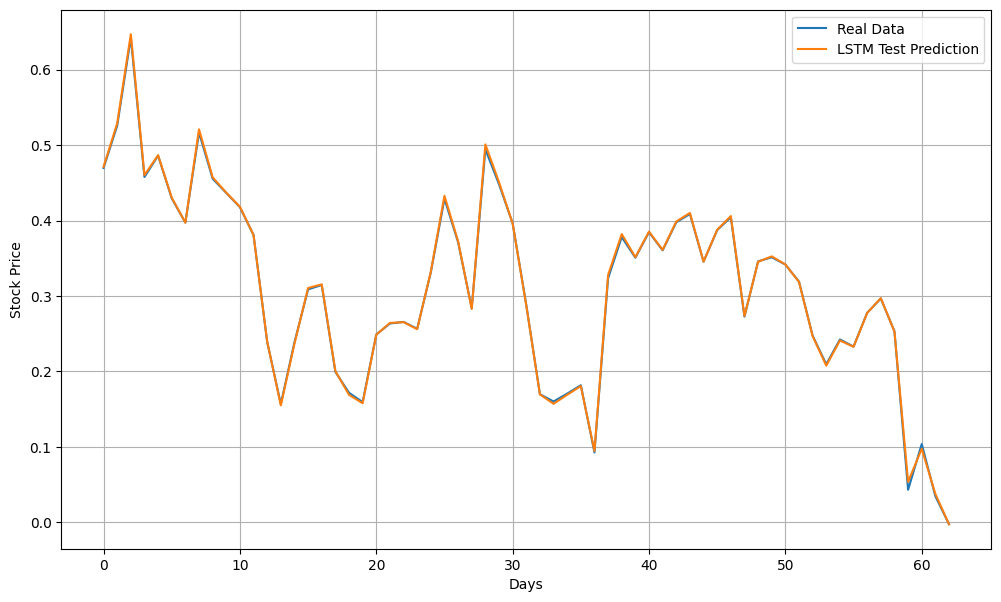

In [17]:
plt.figure(figsize=(12, 7))
plt.plot(range(len(df_test)), df_test[columns], label = "Real Data")
plt.plot(range(len(df_test)), df_test["Model Forecast"], label = "LSTM Test Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.legend()
plt.show()

In [18]:
# df_test.to_csv('AAPL_2022-01-01_2023-01-01_LSTM.csv', index=False)

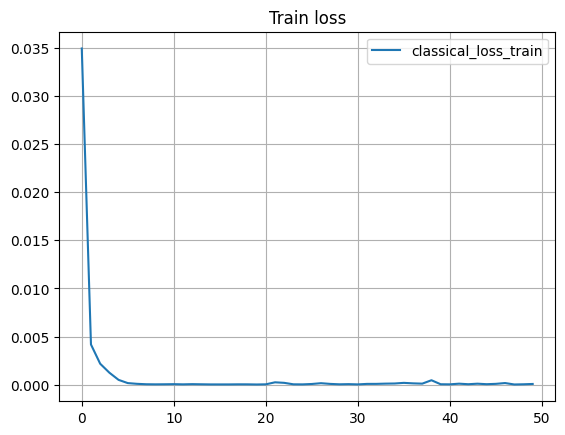

In [19]:
plt.plot(classical_loss_train, label='classical_loss_train')
# plt.plot(classical_loss_test, label='classical_loss_test')
pd.DataFrame(classical_loss_train).to_csv('LSTM_loss.csv', index=False)
plt.title('Train loss')
plt.legend()

In [20]:
# Calculate the RMSE for the train and test data
from sklearn.metrics import mean_squared_error

train_rmse = math.sqrt(mean_squared_error(df_train[columns], df_train["Model Forecast"]))
test_rmse = math.sqrt(mean_squared_error(df_test[columns], df_test["Model Forecast"]))
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 0.0030914583833342333
Test RMSE: 0.002449594026262347


Train RMSE: 0.004553309809231617
Test RMSE: 0.004868512148952862

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

# Calculate metrics for train data
train_rmse = math.sqrt(mean_squared_error(df_train["Close"], df_train["Model Forecast"]))
train_mae = mean_absolute_error(df_train["Close"], df_train["Model Forecast"])
# Avoid division by zero in MAPE calculation
train_mape = np.mean(np.abs((df_train["Close"] - df_train["Model Forecast"]) / np.maximum(np.abs(df_train["Close"]), 1e-10))) * 100

# Calculate metrics for test data
test_rmse = math.sqrt(mean_squared_error(df_test["Close"], df_test["Model Forecast"]))
test_mae = mean_absolute_error(df_test["Close"], df_test["Model Forecast"])
# Avoid division by zero in MAPE calculation
test_mape = np.mean(np.abs((df_test["Close"] - df_test["Model Forecast"]) / np.maximum(np.abs(df_test["Close"]), 1e-10))) * 100

# Print all metrics
print("Training Data Metrics:")
print(f"RMSE: {train_rmse:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"MAPE: {train_mape:.2f}%")
print("\nTest Data Metrics:")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"MAPE: {test_mape:.2f}%")

Training Data Metrics:
RMSE: 0.0031
MAE: 0.0027
MAPE: 41786303.06%

Test Data Metrics:
RMSE: 0.0024
MAE: 0.0016
MAPE: 1.07%


In [22]:
# Calculate the accuracy of the model
def accuracy(y, y_star):
    return np.mean(np.abs(y - y_star) < 0.1)

train_accuracy = accuracy(df_train["Close"], df_train["Model Forecast"])
test_accuracy = accuracy(df_test["Close"], df_test["Model Forecast"])
print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")

Train accuracy: 1.0
Test accuracy: 1.0
